<hr>

# <center>Aplicación de un Algoritmo tipo MMC para el Diseño de la Ciclovía de la CDMX</center> <a class="tocSkip"></a>

# El análogo del Modelo de Ising

El algoritmo de Metropolis es ampliamente aplicado en simulaciones computacionales del modelo de Ising, en el que se estudia un sistema físico que consta de partículas dispuestas en un *lattice* cuyas interacciones entre sí mismas y con un campo externo determinan su estado (que toma los valores de +1 o -1) y por ende el estado global del sistema dada una temperatura.

Mi objetivo en este trabajo es proponer un algoritmo de tipo Metropolis-MonteCarlo que permita optimizar el diseño de las ciclovías de la Ciudad de México dado un presupuesto, un campo de necesidades y los diferentes estados que puede tomar cada calle dentro de una red, analizando cada par de distritos conectados por separado. 

## Los estados y la *lattice*

### Los estados posibles por calle
Primero es necesario crear el objeto computacional con el que voy a tratar, que es una red de calles con distintos estados posibles. Los estados que voy a considerar son

| $  | ID  | cap | att | características del carril                  |
|----|-----|-----|-----|---------------------------------------------|
| 13 | CTR | 4   | 7   | calle cetram                                |
| 12 | ESS | 3   | 6   | exclusivo con ecobici y biciestacionamiento |
| 11 | ESN | 3   | 5   | exclusivo con ecobici                       |
| 10 | ENS | 3   | 4   | exclusivo con biciestacionamiento           |
| 19 | ENN | 3   | 3   | exclusivo sin estaciones                    |
| 8  | BSS | 2   | 5   | bus-bici con ecobici y biciestacionamiento  |
| 7  | BSN | 2   | 4   | bus-bici con ecobici                        |
| 6  | BNS | 2   | 3   | bus-bici con biciestacionamiento            |
| 5  | BNN | 2   | 2   | bus-bici sin estaciones                     |
| 4  | MSS | 1   | 4   | mixto con ecobici y biciestacionamiento     |
| 3  | MSN | 1   | 3   | mixto con ecobici                           |
| 2  | MNS | 1   | 2   | mixto con biciestacionamiento               |
| 1  | MNN | 1   | 1   | mixto sin estaciones                        |
| 0  | NNN | 0   | 0   | sin ciclovía                                |

<div class="alert alert-block alert-info">
<FONT COLOR="#baba45">
<i>Definición.</i> Entonces, el <b>vector de estado</b> $\vec{S}$ de una calle se define como $$\vec{S} = (s,\$, \text{id},c_s,a_s)$$ donde: $s$ es el valor de spin (el que se utilizará en el término de interacción entre vecinos del hamiltoniano) del estado, $ \$ $ es el costo por metro lineal del estado, $\text{id}$ es el identificador, $c_s$ es la capacidad de uso del estado, $a_s$ es la capacidad de atracción y conversión de usuarios del estado.
</FONT>
</div> 
En la siguiente celda defino la estructura en Julia.

In [1]:
struct streetState
    id::String # Identificador de un estado
    
    #= Características asignadas =#
    spin::Int # el "spin" del estado
    cost::Float64 # el costo por longitud del estado
    cap::Int # la capacidad de diseño del estado
    attPot::Int # potencial de intercambio de modo de transporte
    
    #= Los valores a calcular =#
    intField::Float64 # el valor de interacción del estado con el campo localmente
    totCost::Float64 # el valor de costo total del estado dada su existencia en la red (costo por longitud total)
end

#= Tabla de Estados posibles =#
listStates = [[-1,0,"NNN",0,0],
               [1,1,"MNN",1,1],
               [1,2,"MNS",1,2],
               [1,3,"MSN",1,3],
               [1,4,"MSS",1,4],
               [1,5,"BNN",2,2],
               [1,6,"BNS",2,3],
               [1,7,"BSN",2,4],
               [1,8,"BSS",2,5],
               [1,9,"ENN",3,3],
               [1,10,"ENS",3,4],
               [1,11,"ESN",3,5],
               [1,12,"ESS",3,6],
               [1,13,"CTR",4,7]]

""" Constructor de StreetState """
function constructState!(s::streetState,x::Int) 
    index = x+1
    s.spin = listStates[index][1]
    s.cost = x
    s.id = listStates[index][3]
    s.cap = listStates[index][4]
    s.attPot = listStates[index][5]
end

setTotCost!(s::streetState, x::Float64) = s.totCost = x
setifl!(s::streetState, x::Float64) = s.intField = x

setifl! (generic function with 1 method)

***
### La *lattice*: la red de calles
La red de calles será la que esté delimitada por las regiones geográficas que ocupen los dos distritos en cuestión, se requieren las coordenadas de cada una de las calles de la red, sus características y la lista de vecinos. En la siguiente celda defino la estructura en Julia correspondiente a la red de calles, con los atributos necesarios que permitan calcular las interacciones con la red de ciclovías.

In [3]:
struct streetNetwork
    #= Entradas =#
    coords::Vector{Vector{NTuple{2,Float64}}} # Lista de listas de coordenadas de cada calle de la red
    longs::Vector{Float64} # Lista de longitudes REALES de cada calle en la red
    neighbors::Vector{Vector{Int}} # Lista de listas de outneighbors de cada calle de la red
    usrDnst::Vector{Float64} # Lista de densidades de potenciales usuarios de la red por cada calle (densidad de población,
                             # densidad máxima de automovilistas con base el el peor tiempo por arista)
    demand::Float64 # Demanda de usuarios por conexión entre pares adyacentes (de la encuesta de OD2017)
    dstrCoords::Vector{NTuple{2,Float64}} # Coordenadas de los puntos notables de los distritos (pueden ser centroides)
    mariana::Vector{Float64} # Lista de peor tiempo de recorrido por calle en la red (resultados de Mariana)
    abraham::Vector{Float64} # Lista de cantidad de contaminación por calle de la red (resultados de Abraham)
    locField::Vector{Vector{Float64}} # Lista con los vectores del campo para cada calle de la red
    
    #= Salidas =#
    states::Vector{streetState} # Lista de estados de las calles de la red
    totBikewaysCost::Float64 # el costo total de la red de ciclovías
end

setlocFieldi!(sn::streetNetwork,i::Int,f::Vector{Float64}) = sn.locField[i] = f
setBikewaysCost!(sn::streetNetwork,c::Float64) = s.totBikewaysCost = c
setStatei!(sn::streetNetwork,i::Int,s::streetState) = sn.states[i] = s

setStatei! (generic function with 1 method)

## El  campo y las interacciones con los estados

### El campo local inicial
En principio, propongo un campo con 4 entradas asociadas con las necesidades de ciclovía, el impacto al tránsito y la exposición a la contaminación, entonces 
<div class="alert alert-block alert-info">
<FONT COLOR="#baba45">
    <i>Definición.</i> el <b>vector de campo local</b> $\vec{B_i}$ se define como $$\vec{B_i} = (d \times u_n,d \times p_n,t,e) = (u_{wn},p_{wn},t,e)$$ donde, para la $i$-ésima calle: $u_n$ es la demanda de usuarios (por enlace entre pares), $p_n$ es la densidad de potenciales usuarios (por región), $t$ es el impacto al tránsito que tiene el estado de la calle, $e$ es la exposición a la contaminación de la calle. Los dos primeros términos están pesados por una distribución normal $d$ centrada en la ruta ideal entre (el vector que une) cada par de distritos.
</FONT>
</div> 
La distribución normal está asociada con la magnitud del campo, que es mayor en las calles cercanas a la ruta ideal. En la siguiente celda defino las funciones que realizarán los cálculos básicos para $d$, $l_f$ y los cálculos iniciales del campo local de toda la red.

In [4]:
""" Calcula la función de peso para la demanda """
function d(sn::streetNetwork,i::Int)
    x1 = sn.dstrCoords[1][1] # coordenada x del primer punto notable
    y1 = sn.dstrCoords[1][2] # coordenada y del primer punto notable
    x2 = sn.dstrCoords[2][1] # coordenada x del segundo punto notable
    y2 = sn.dstrCoords[2][2] # coordenada y del segundo punto notable
    x01 = sn.coords[i][1][1] # coordenada x del punto inicial de la i-ésima calle
    y01 = sn.coords[i][1][2] # coordenada y del punto inicial de la i-ésima calle
    x02 = sn.coords[i][2][1] # coordenada x del punto final de la i-ésima calle
    y02 = sn.coords[i][2][2] # coordenada x del punto final de la i-ésima calle
    
    #= La distancia entre las esquinas de la i-ésima calle y la línea que une al par de distritos =#
    ydiff = y2-y1
    xdiff = x2-x1
    xyp = x2*y1-x1*y2
    sqxy = sqrt(ydiff^2 + xdiff^2)
    r1 = abs(ydiff*x01-xdiff*y01+xyp)/sqxy
    r2 = abs(ydiff*x02-xdiff*y02+xyp)/sqxy
    
    #= el valor de sigma debe modificarse como función de la distancia que un ciclista estaría dispuesto a 
    desviarse de la ruta ideal (Encuesta)=#
    σ = 1
    d1 = (1/(2*π*σ^2))*exp(r1^2/(2/σ^2))
    d2 = (1/(2*π*σ^2))*exp(r2^2/(2/σ^2))
    d = (d1+d2)/2
    return d
end

""" Calcula el vector de campo para una calle, con base en la demanda """
function localField(sn::streetNetwork,i::Int)
    w = d(sn,i)
    uwn = w*sn.demand
    pwn = w*sn.usrDnst[i] 
    ##############################
    #= estos valores están determinados por los resultados de Mariana y de Abraham =#
    t = mariana[i] # el peor tiempo por arista
    f = [uwn,pwn,t,abraham[i]] # la contaminación sólo se va a calcular una vez
    setlocFieldi!(sn,i,f)
end

""" Asigna vectores de campo a todas las calles de la red """
function Btot(sn::streetNetwork)
    for i in 1:length(sn.states)
        localField(sn,i)
    end
end

Btot (generic function with 1 method)

***
### Las interacciones de un estado con el campo local
Para definir las interacciones entre el estado de una calle y el campo voy a considerar la diferencia entre las características de diseño y lo que demanda la sociedad. 

<div class="alert alert-block alert-info">
<FONT COLOR="#baba45">
    <i>Definición.</i> Entonces, se define la <b>operación producto interno</b> como $$\langle\vec{B_i},\vec{S_i}\rangle = ||(u_{wn}-c_s,p_{wn}-a_s,t,e)||= \sqrt{(u_{wn}-c_s)^2+(p_{wn}-a_s)^2+t^2+e^2}$$
</FONT>
</div> 
En la siguiente celda defino la función de interacción.

In [5]:
""" Calcula la interacción entre el i-ésimo vector de estado y el i-ésimo vector de campo local"""
function interBiSi(sn::streetNetwork,i::Int,s::streetState)
    fieldi = sn.locField[i]
    # statei = sn.states[i]
    uwn = fieldi[1]
    pwn = fieldi[2]
    t = fieldi[3]
    e = fieldi[4]
    cs = s.cap
    as = s.attPot
    inter = sqrt((uwn-cs)^2+(pwn-as)^2+t^2+e^2)
    setifl!(s, inter)
    # return inter
end

interBiSi (generic function with 1 method)

## El Hamiltoniano

<div class="alert alert-block alert-info">
<FONT COLOR="#baba45">
    <i>Definición.</i> El <b>hamiltoniano</b> que representa la energía a minimizar es entonces
$$ H = -J \sum_{<i,j>}^{N} \sigma_i \sigma_j + \sum_i^N \langle\vec{B_i},\vec{S_i}\rangle + \sum_{\sigma_i=1}^N l_i \$\_i $$

donde:
- el primer término controla la conectividad (es mínimo cuando existe toda la ciclovía o cuando no existe ninguna en la red)
- el segundo término controla la interacción de los estados de las calles con el campo (es mínimo cuando los estados interactúan mejor con el campo local)
- el tercero controla el costo de la ciclovía (es mínimo cuando el costo es el menor)
</FONT>
</div> 
Hay que notar que el segundo y el tercer término son siempre positivos y actúan como penalizaciones a la minimización de la energía. En la siguiente celda defino la función que calcula el costo total de un estado y el hamiltoniano de la red.

In [6]:
""" Calcula el costo total de un estado aplicado en una calle específica """
function costi(sn::streetNetwork,i::Int,s::streetState)
    # statei = sn.states[i]
    longi = sn.longs[i]
    costi = s.cost
    totCost = longi*costi
    setTotCost!(s, totCost)
    # return totCost
end

""" Calcula el Hamiltoniano total de la red """
function Htot(sn::streetNetwork,J::Float64)
    interList = []
    costList = []
    interTerm = 0
    for i in 1:length(sn.states)
        statei = sn.states[i]
        costi(sn,i,statei)
        interBiSi(sn,i,statei)
        push!(costList,statei.totCost)
        push!(interList,statei.intField)
        for j in sn.neighbors[i]
            statej = sn.states[j]
            interTerm += (J/2)*statei.spin*statej.spin
        end
    end
    fieldTerm = sum(interList)
    costTerm = sum(costList)
    setBikewaysCost!(sn,costTerm)
    Htot = interTerm + fieldTerm + costTerm
end

Htot (generic function with 1 method)

# Termalización aplicando un algoritmo tipo MMC, suponiendo una distribución de Boltzmann

Para el proceso de termalización, voy a suponer que la probabilidad de que el sistema cambie de estado (si aleatoriamente se modifica uno de sus spines) sigue una distribución de Boltzmann dada por

$$ p = \exp\left(-\frac{H_2 - H_1}{k_B T}\right) $$

Y a partir de ahí calcular todas las demás propiedades del sistema. La función ```mmcIsingCiclovia``` realiza esos cálculos.

In [7]:
""" Algoritmo de MetropolisMonteCarlo aplicado a la red de calles """
function mmcIsingCiclovia!(sn::streetNetwork,J::Float64,T::Float64)
    nstates = length(sn.states)
    stateToChangeIndex = rand(1:nstates)
    stateToChange = sn.states[stateToChangeIndex]
    partialInterTermOrig = 0
    for j in sn.neighbors[stateToChangeIndex]
        statej = sn.states[j]
        partialInterTermOrig += (J/2)*stateToChange.spin*statej.spin
    end
    itrOrig = interBiSi(sn,randomStateSelector,stateToChange)
    cstOrig = costi(sn,randomStateSelector,stateToChange)
    HOrig = partialInterTermOrig + itrOrig + cstOrig
    
    partialInterTermChanged = 0
    changedState = streetState()
    numberOfPossibleStates = length(listStates)
    randomStateSelector = rand(1:numberOfPossibleStates)
    constructState!(changedState,randomStateSelector)
    for j in sn.neighbors[stateToChangeIndex]
        statej = sn.states[j]
        partialInterTermChanged += (J/2)*changedState.spin*statej.spin
    end
    itrChanged = interBiSi(sn,randomStateSelector,changedState)
    cstChanged = costi(sn,randomStateSelector,changedState)
    HChanged = partialInterTermChanged + itrChanged + cstChanged
    
    deltaH = HChanged - HOrig
    p = exp(-(deltaH/T))
    if p > rand()
        setStatei!(sn,stateToChangeIndex,changedState)
    end
end

mmcIsingCiclovia! (generic function with 1 method)

# Una streetNetwork de prueba

In [8]:
using PyCall, PyPlot

# Importando matplotlib.pyplot desde python
plt = pyimport("matplotlib.pyplot")
patches = pyimport("matplotlib.patches")

# El tema que se va a utilizar en las figuras
jtp = pyimport("jupyterthemes.jtplot")
jtp.style(theme="chesterish");

┌ Info: Recompiling stale cache file /home/arthurod/.julia/compiled/v1.2/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1240


## Topología básica de la red cuadrada

In [9]:
n=20

function periodic(x,n)
    if x % n != 0
        return x % n
    else
      return n
    end
end
    
function vector(x,y,n)
    return (y-1)*n + x
end

dx = [rand([1,-1,0]) for i in 1:n]
dy = [rand([1,-1,0]) for i in 1:n]

function squareTestStreetNetwork(n)
    outNeighbors = []
    coords = []
    for y in 1:n
        for x in 1:n
            push!(coords,(x,y))
            vi = []
            if dx[y] != 0
                xv = periodic(x+dx[y],n)
                push!(vi,vector(xv,y,n))
            end
            if dy[x] != 0
                yv = periodic(y+dy[x],n)
                push!(vi,vector(x,yv,n))
            end
            if dx[y] == 0
                xl = periodic(x-1,n); xr = periodic(x+1,n)
                push!(vi,vector(xl,y,n))
                push!(vi,vector(xr,y,n))
            end
            if dy[x] == 0
                yu = periodic(y+1,n); yd = periodic(y-1,n)
                push!(vi,vector(x,yu,n))
                push!(vi,vector(x,yd,n))
            end
            push!(outNeighbors,vi)
        end
    end
    return coords, outNeighbors
end

squareTestStreetNetwork (generic function with 1 method)

In [10]:
testN = squareTestStreetNetwork(n);

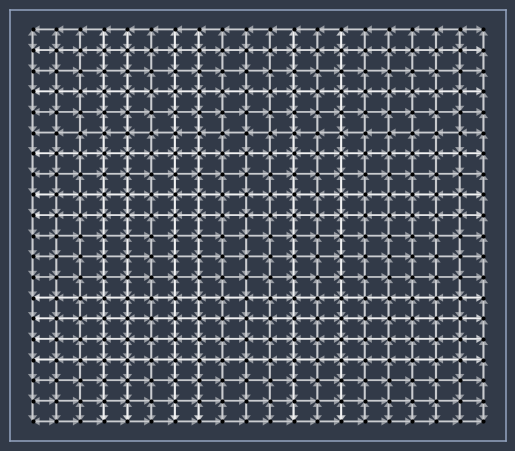

In [11]:
for i in 1:length(testN[1])
    plt.plot(testN[1][i][1],testN[1][i][2],"o",color="black",markersize=3)
    for j in testN[2][i]
        deltax = testN[1][j][1] - testN[1][i][1]
        deltay = testN[1][j][2] - testN[1][i][2]
        plt.arrow(testN[1][i][1],testN[1][i][2],deltax,deltay,head_length=1.5*n/100, head_width=2*n/100, width=4.5*n/1000, alpha=0.5, length_includes_head="True", fc="w")
    end
    plt.yticks([])
    plt.xticks([])
end

## La densidad de potenciales usuarios

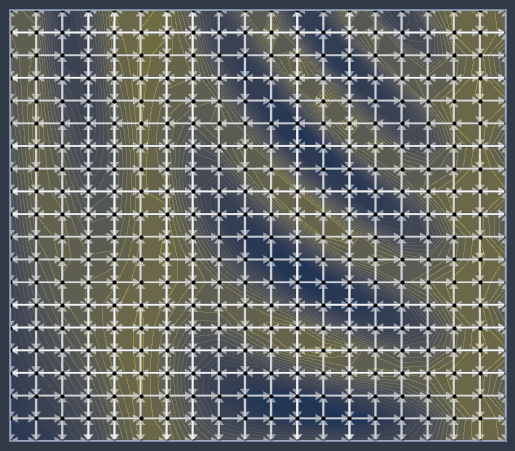

In [24]:
for i in 1:length(testN[1])
    plt.plot(testN[1][i][1],testN[1][i][2],"o",color="black",markersize=3)
    for j in testN[2][i]
        deltax = testN[1][j][1] - testN[1][i][1]
        deltay = testN[1][j][2] - testN[1][i][2]
        plt.arrow(testN[1][i][1],testN[1][i][2],deltax,deltay,head_length=1.5*n/100, head_width=2*n/100, width=4.5*n/1000, alpha=0.5, length_includes_head="True", fc="w")
    end
    plt.yticks([])
    plt.xticks([])
end

function f(x, y)
    return 1 + sin(0.25*x) ^ 10 + cos(10 + 0.35*y * 0.25*x) * cos(0.25*x)
end

basex = collect(1:1:n)
basey = collect(1:1:n)
Z = zeros(Float64,1*n,1*n)

indx = 1
for i in basex
    indy = 1
        for j in basey
        Z[indx,indy] = f(j, i)
        indy += 1
    end
    indx += 1
end

plt.contourf(basex, basey, Z, 20, cmap="cividis", alpha=0.3);

## Peor tiempo por arista de la red

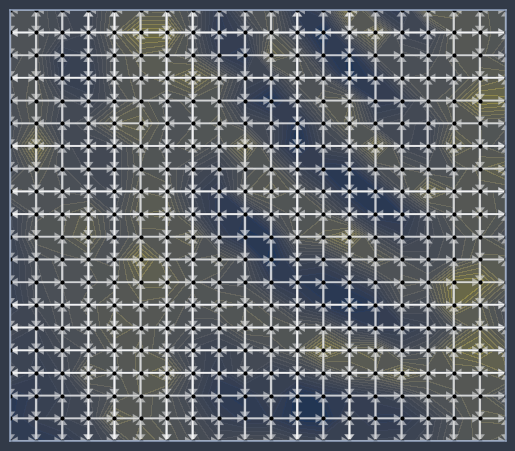

In [22]:
for i in 1:length(testN[1])
    plt.plot(testN[1][i][1],testN[1][i][2],"o",color="black",markersize=3)
    for j in testN[2][i]
        deltax = testN[1][j][1] - testN[1][i][1]
        deltay = testN[1][j][2] - testN[1][i][2]
        plt.arrow(testN[1][i][1],testN[1][i][2],deltax,deltay,head_length=1.5*n/100, head_width=2*n/100, width=4.5*n/1000, alpha=0.5, length_includes_head="True", fc="w")
    end
    plt.yticks([])
    plt.xticks([])
end

function f(x, y)
    return 1 + sin(0.25*x) ^ 10 + cos(10 + 0.35*y * 0.25*x) * cos(0.25*x) + rand([1,1/2,1/3,1/4,1/5,1/6,1/7])
end

basex = collect(1:1:n)
basey = collect(1:1:n)
Z = zeros(Float64,1*n,1*n)

indx = 1
for i in basex
    indy = 1
        for j in basey
        Z[indx,indy] = f(j, i)
        indy += 1
    end
    indx += 1
end

plt.contourf(basex, basey, Z, 20, cmap="cividis", alpha=0.3);

In [25]:
Z

20×20 Array{Float64,2}:
 0.236187  0.358657  0.532039  …  1.11905   1.68129  2.01621  1.85169
 0.291205  0.472638  0.689908     0.920386  1.62081  2.02024  1.82618
 0.351646  0.602747  0.870505     1.47233   1.91361  1.96469  1.40299
 0.417048  0.745011  1.06146      1.76283   1.97163  1.97083  1.57937
 0.48691   0.895084  1.24968      1.25923   1.67834  2.02526  1.93968
 0.560698  1.04838   1.42229   …  0.884927  1.62279  2.00915  1.63485
 0.637847  1.20022   1.56744      1.32624   1.91654  1.95768  1.38321
 0.717767  1.34596   1.6752       1.77398   1.96963  1.98321  1.77774
 0.799847  1.48116   1.73819      1.40717   1.67543  2.03001  1.88874
 0.883458  1.60167   1.75209      0.898393  1.62481  1.9959   1.45463
 0.967961  1.70383   1.71594   …  1.18054   1.91944  1.95535  1.49839
 1.05271   1.7845    1.63223      1.73627   1.96758  1.99689  1.9169 
 1.13705   1.84123   1.50668      1.54659   1.67255  2.02983  1.72394
 1.22035   1.87229   1.34791      0.959303  1.62689  1.98226  1.37

# Red de calles de Santiago



In [8]:
using JSON, GeoJSON
using DataFrames, DataFramesMeta
testNetworkNodesDict = geo2dict(GeoJSON.parsefile("little-network-test-inner-nodes.geojson"))
testNetworkNodesList = get(testNetworkNodesDict,"features", 1)
testNetworkNodes_df = DataFrame(id_nodo = Int64[], x = Float64[], y = Float64[])
for i in 1:size(testNetworkNodesList,1)
    id = get(get(testNetworkNodesList[i],"properties", 1),"id", 1)
    x = get(get(testNetworkNodesList[i],"geometry", 1),"coordinates", 1)[1][1]
    y = get(get(testNetworkNodesList[i],"geometry", 1),"coordinates", 1)[1][2]
    push!(testNetworkNodes_df,[id,x,y])
end
sort!(testNetworkNodes_df)
first(testNetworkNodes_df,30)

┌ Info: Recompiling stale cache file /home/arthurod/.julia/compiled/v1.1/GeoJSON/l1tgg.ji for GeoJSON [61d90e0f-e114-555e-ac52-39dfb47a3ef9]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/arthurod/.julia/compiled/v1.1/DataFrames/AR9oZ.ji for DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/arthurod/.julia/compiled/v1.1/DataFramesMeta/2xRTO.ji for DataFramesMeta [1313f7d8-7da2-5740-9ea0-a2ca25f37964]
└ @ Base loading.jl:1184


,id_nodo,x,y
,Int64,Float64,Float64
1,1,-99.1611,19.4221
2,2,-99.161,19.4215
3,4,-99.1572,19.4213
4,5,-99.157,19.4206
5,7,-99.1618,19.4232
6,8,-99.1616,19.4226
7,13,-99.165,19.4206
8,14,-99.1639,19.4209
9,16,-99.1654,19.4158


In [9]:
size(testNetworkNodes_df)

(1729, 3)

In [41]:
testNetworkEdgesDict = JSON.parsefile("little-network-test-roads.json")
testNetworkFeaturesList = get(testNetworkEdgesDict,"features", 1)
testNetworkEdges_df = DataFrame(nodo_origen = Int64[], nodo_destino = Int64[], camino = Array[])
for i in 1:size(testNetworkFeaturesList,1)
    tp = get(get(testNetworkFeaturesList[i],"geometry", 1),"type", 1)
    if tp == "LineString"
        id_from = get(testNetworkFeaturesList[i],"from",0)
        id_to = get(testNetworkFeaturesList[i],"to",0)
        crds = get(get(testNetworkFeaturesList[i],"geometry", 1),"coordinates",1)
        push!(testNetworkEdges_df,[id_from,id_to,crds])
    end
end
sort!(testNetworkEdges_df)
first(testNetworkEdges_df,30)

,nodo_origen,nodo_destino,camino
,Int64,Int64,Array
1,1,2,"[Any[-99.1611, 19.4221], Any[-99.1611, 19.422], Any[-99.161, 19.4215]]"
2,2,8374,"[Any[-99.161, 19.4215], Any[-99.1609, 19.4211], Any[-99.1609, 19.4211], Any[-99.1609, 19.421], Any[-99.1609, 19.421]]"
3,4,5,"[Any[-99.1572, 19.4213], Any[-99.157, 19.4206]]"
4,5,4484,"[Any[-99.157, 19.4206], Any[-99.1563, 19.4207]]"
5,7,8,"[Any[-99.1618, 19.4232], Any[-99.1616, 19.4226]]"
6,8,1202,"[Any[-99.1616, 19.4226], Any[-99.1622, 19.4224]]"
7,10,11,"[Any[-99.1594, 19.4246], Any[-99.1596, 19.4246], Any[-99.1612, 19.4242]]"
8,10,7842,"[Any[-99.1594, 19.4246], Any[-99.1596, 19.4246], Any[-99.1602, 19.4245]]"
9,11,1172,"[Any[-99.1612, 19.4242], Any[-99.1646, 19.4234]]"


In [43]:
size(testNetworkEdges_df)

(5896, 3)

In [52]:
using PyCall
bpl = pyimport("bokeh.plotting")
btp = pyimport("bokeh.tile_providers")
prj = pyimport("pyproj")

bpl.output_file("TestNetworkFigure1.html", mode="inline")
tile_provider = btp.get_provider(btp.Vendors.CARTODBPOSITRON_RETINA)
p = bpl.figure(title="TestNetworkFigure1", x_range=(-11041695.7413, -11034930.2781), y_range=(2201803.3251, 2205243.2833),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(tile_provider)

merc_coords_nodes = prj.transform(prj.Proj(init="epsg:4326"), prj.Proj(init="epsg:3857"), testNetworkNodes_df.x, testNetworkNodes_df.y)
p.square(merc_coords_nodes[1], merc_coords_nodes[2], size=3, color="olive", alpha=0.8)

for i in 1:size(testNetworkEdges_df,1)
    x_way = []
    y_way = []
    for j in 1:size(testNetworkEdges_df.camino[i],1)
        push!(x_way,testNetworkEdges_df.camino[i][j][1])
        push!(y_way,testNetworkEdges_df.camino[i][j][2])
    end
    merc_coords_edge = prj.transform(prj.Proj(init="epsg:4326"), prj.Proj(init="epsg:3857"), x_way, y_way)
    p.line(merc_coords_edge[1], merc_coords_edge[2], color="#323a48", line_width=1, alpha=0.8)
end

bpl.save(p)

"/home/arthurod/programming/npb-cdmx/TestNetworkFigure1.html"

In [100]:
nodes_from = []
nodes_to = []
routes = []
for i in 1:size(testNetworkEdges_df,1)
    x_from = (@linq testNetworkNodes_df |>
           where(:id_nodo .== testNetworkEdges_df.nodo_origen[i]) |>
           select(:x, :y)).x
    y_from = (@linq testNetworkNodes_df |>
           where(:id_nodo .== testNetworkEdges_df.nodo_origen[i]) |>
           select(:x, :y)).y
    x_to = (@linq testNetworkNodes_df |>
           where(:id_nodo .== testNetworkEdges_df.nodo_destino[i]) |>
           select(:x, :y)).x
    y_to = (@linq testNetworkNodes_df |>
           where(:id_nodo .== testNetworkEdges_df.nodo_destino[i]) |>
           select(:x, :y)).y
    if size(x_from,1) != 0 && size(y_from,1) != 0 && size(x_to,1) != 0 && size(y_to,1) != 0
        push!(nodes_from,testNetworkEdges_df.nodo_origen[i])
        push!(nodes_to,testNetworkEdges_df.nodo_destino[i])
        push!(routes,testNetworkEdges_df.camino[i])
    end
end
testNetworkInnerEdges_df = DataFrame(nodo_origen = Int64[], nodo_destino = Int64[], camino = Array[])
for i in 1:length(routes)
    push!(testNetworkInnerEdges_df, [nodes_from[i], nodes_to[i], routes[i]])
end
sort!(testNetworkInnerEdges_df)
first(testNetworkInnerEdges_df,30)

,nodo_origen,nodo_destino,camino
,Int64,Int64,Array
1,1,2,"[Any[-99.1611, 19.4221], Any[-99.1611, 19.422], Any[-99.161, 19.4215]]"
2,2,8374,"[Any[-99.161, 19.4215], Any[-99.1609, 19.4211], Any[-99.1609, 19.4211], Any[-99.1609, 19.421], Any[-99.1609, 19.421]]"
3,4,5,"[Any[-99.1572, 19.4213], Any[-99.157, 19.4206]]"
4,5,4484,"[Any[-99.157, 19.4206], Any[-99.1563, 19.4207]]"
5,7,8,"[Any[-99.1618, 19.4232], Any[-99.1616, 19.4226]]"
6,8,1202,"[Any[-99.1616, 19.4226], Any[-99.1622, 19.4224]]"
7,13,14,"[Any[-99.165, 19.4206], Any[-99.1639, 19.4209]]"
8,13,3133,"[Any[-99.165, 19.4206], Any[-99.1651, 19.4212]]"
9,14,9015,"[Any[-99.1639, 19.4209], Any[-99.1641, 19.4203]]"


In [102]:
bpl.output_file("TestNetworkFigureTrimmedEdges.html", mode="inline")
tile_provider = btp.get_provider(btp.Vendors.CARTODBPOSITRON_RETINA)
p = bpl.figure(title="TestNetworkFigureTrimmedEdges", x_range=(-11041695.7413, -11034930.2781), y_range=(2201803.3251, 2205243.2833),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(tile_provider)

merc_coords_nodes = prj.transform(prj.Proj(init="epsg:4326"), prj.Proj(init="epsg:3857"), testNetworkNodes_df.x, testNetworkNodes_df.y)
p.square(merc_coords_nodes[1], merc_coords_nodes[2], size=3, color="olive", alpha=0.8)

for i in 1:size(testNetworkInnerEdges_df,1)
    x_way = []
    y_way = []
    for j in 1:size(testNetworkInnerEdges_df.camino[i],1)
        push!(x_way,testNetworkInnerEdges_df.camino[i][j][1])
        push!(y_way,testNetworkInnerEdges_df.camino[i][j][2])
    end
    merc_coords_edge = prj.transform(prj.Proj(init="epsg:4326"), prj.Proj(init="epsg:3857"), x_way, y_way)
    p.line(merc_coords_edge[1], merc_coords_edge[2], color="#323a48", line_width=1, alpha=0.8)
end

bpl.save(p)

"/home/arthurod/programming/npb-cdmx/TestNetworkFigureTrimmed.html"

In [104]:
last(testNetworkInnerEdges_df,10)

,nodo_origen,nodo_destino,camino
,Int64,Int64,Array
1,9089,3459,"[Any[-99.1752, 19.4133], Any[-99.1749, 19.4131]]"
2,9182,3932,"[Any[-99.1457, 19.4087], Any[-99.1458, 19.4084]]"
3,9210,6516,"[Any[-99.1723, 19.4118], Any[-99.1723, 19.4116]]"
4,9210,7872,"[Any[-99.1723, 19.4118], Any[-99.1724, 19.4115]]"
5,9332,4414,"[Any[-99.1715, 19.4042], Any[-99.1715, 19.4042]]"
6,9332,8728,"[Any[-99.1715, 19.4042], Any[-99.1714, 19.404]]"
7,9348,3835,"[Any[-99.1551, 19.4066], Any[-99.1551, 19.4066], Any[-99.1552, 19.4066], Any[-99.1552, 19.4066]]"
8,9348,4868,"[Any[-99.1551, 19.4066], Any[-99.1547, 19.4118]]"
9,9366,2896,"[Any[-99.1539, 19.4213], Any[-99.1539, 19.4226]]"


In [119]:
node_ids = []
neighbors_list = [] 
for i in 1:9366
    neighborsi = []
    numberOfNeighbors = size((@linq testNetworkInnerEdges_df |>
               where(:nodo_origen .== i) |>
               select(:nodo_destino)),1)
    if numberOfNeighbors != 0
        for j in 1:numberOfNeighbors
            push!(neighborsi,(@linq testNetworkInnerEdges_df |>
                   where(:nodo_origen .== i) |>
                   select(:nodo_destino)).nodo_destino[j])
        end
    push!(node_ids, i)
    push!(neighbors_list, neighborsi)
    end
end
testNetworkNeighbors_df = DataFrame(id_nodo = Int64[], ids_vecinos = Array[])
for i in 1:length(node_ids)
    push!(testNetworkNeighbors_df, [node_ids[i], neighbors_list[i]])
end
sort!(testNetworkNeighbors_df)
first(testNetworkNeighbors_df,30)

,id_nodo,ids_vecinos
,Int64,Array
1,1,[2]
2,2,[8374]
3,4,[5]
4,5,[4484]
5,7,[8]
6,8,[1202]
7,13,"[14, 3133]"
8,14,[9015]
9,16,"[17, 3591]"


In [124]:
testNetworkInnerNodes_df = join(testNetworkNodes_df, testNetworkNeighbors_df, on = :id_nodo)

,id_nodo,x,y,ids_vecinos
,Int64,Float64,Float64,Array
1,1,-99.1611,19.4221,[2]
2,2,-99.161,19.4215,[8374]
3,4,-99.1572,19.4213,[5]
4,5,-99.157,19.4206,[4484]
5,7,-99.1618,19.4232,[8]
6,8,-99.1616,19.4226,[1202]
7,13,-99.165,19.4206,"[14, 3133]"
8,14,-99.1639,19.4209,[9015]
9,16,-99.1654,19.4158,"[17, 3591]"


In [131]:
bpl.output_file("TestNetworkFigureTrimmedEdgesAndNodes.html", mode="inline")
tile_provider = btp.get_provider(btp.Vendors.CARTODBPOSITRON_RETINA)
p = bpl.figure(title="TestNetworkFigureTrimmedEdgesAndNodes", x_range=(-11041695.7413, -11034930.2781), y_range=(2201803.3251, 2205243.2833),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(tile_provider)

merc_coords_nodes = prj.transform(prj.Proj(init="epsg:4326"), prj.Proj(init="epsg:3857"), testNetworkInnerNodes_df.x, testNetworkInnerNodes_df.y)
p.square(merc_coords_nodes[1], merc_coords_nodes[2], size=3, color="olive", alpha=0.8)

for i in 1:size(testNetworkInnerEdges_df,1)
    x_way = []
    y_way = []
    for j in 1:size(testNetworkInnerEdges_df.camino[i],1)
        push!(x_way,testNetworkInnerEdges_df.camino[i][j][1])
        push!(y_way,testNetworkInnerEdges_df.camino[i][j][2])
    end
    merc_coords_edge = prj.transform(prj.Proj(init="epsg:4326"), prj.Proj(init="epsg:3857"), x_way, y_way)
    p.line(merc_coords_edge[1], merc_coords_edge[2], color="#323a48", line_width=1, alpha=0.8)
end

bpl.save(p)

"/home/arthurod/programming/npb-cdmx/TestNetworkFigureTrimmedEdgesAndNodes.html"

In [130]:
testNetworkInnerNodes_df.y

1689-element Array{Float64,1}:
 19.422060012817383
 19.421541213989258
 19.42129135131836 
 19.420576095581055
 19.423213958740234
 19.422565460205078
 19.42064666748047 
 19.4209041595459  
 19.415834426879883
 19.416976928710938
 19.41234588623047 
 19.412681579589844
 19.417491912841797
  ⋮                
 19.403121948242188
 19.403718948364258
 19.40406036376953 
 19.41306495666504 
 19.420297622680664
 19.42034339904785 
 19.413288116455078
 19.408721923828125
 19.411785125732422
 19.40424346923828 
 19.406566619873047
 19.421281814575195